# Python Learn by Doing: Climate Change Indicators

Developed By: Dr. Kerrie Geil, Mississippi State University

Date: January 2024

Requirements: list space, RAM, and pacakge requirements

Link: notebook available to download at 

<u> Description </u>

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around obtaining climate data, computing climate change indices, and determining the statistical significance of change. The notebook is aimed at learners who already have some knowledge of programming and statistics. 

<u> Summary of Contents </u>

put an outline of tasks/skills here

-----

# Introduction to Climate Change Indicators

Put a description of what they are

Include a bunch of links

Spell out which ones we will be computing

Selection of ETCCDI Climate Extremes Indices
- Monthly Maximum Value of Daily Minimum Temperature (TNx)
- Growing Season Length (GSL)
- Warm Spell Duration Index (WSDI)
- Monthly Maximum Consecutive 5-day Precipitation (Rx5day)
- Maximum Length of Consecutive Dry Days (CDD)
- Annual Total Precip Amount Over 99th Percentile of Wet Days (R99pTOT)

**Disclaimer:** This notebook is intended for python programming learning only. The data quality checking and calculation of ETCCDI climate change indices in this notebook may differ slightly from the ETCCDI published instructions for simplicity and/or relevance to our learning goals. Learners wanting to compute the indices according to the exact ETCCDI instructions should consult their [documentation](https://etccdi.pacificclimate.org/index.shtml) or use the [RClimDex software package](https://github.com/ECCC-CDAS/RClimDex.git) written in R to calculate ETCCDI climate change indices. The indices calculated from multiple gridded datasets are available from [climdex.org](https://www.climdex.org/), which also offers a similar software package for calculating the indices on a dataset of your choice.   


For the climate change indices covered in this notebook we will need the following observational data over many data years:

variable abbrev. | description | frequency | units
---|---|---|---
tmin | minimum surface air temperature | daily | C 
tmax | maximum surface air temperature | daily | C
prcp | accummulated precipitation | daily | mm/day

# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import os
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
import pandas as pd

import numpy.testing as npt
import warnings

import matplotlib.pyplot as plt
# import gzip
# import shutil

# import pandas as pd

In [2]:
# learners need to update these paths to reflect locations on their own computer/workspace

# path to your working directory (where this notebook is on your computer)
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/climate_change_indicators/' 
# work_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/climate_change_indicators/' 

# path to where you'll download and store the data files
data_dir = r'C://Users/kerrie/Documents/02_LocalData/tutorials/AgERA5_daily/' 

# path to write output files and figures
output_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/climate_change_indicators/outputs/'
# output_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/climate_change_indicators/outputs/'


# create directories if they don't exist already
# if not os.path.exists(work_dir):
#     os.makedirs(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Obtaining the Data

We will use the AgERA5 gridded dataset in this notebook, obtained from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=overview). Data file are temporarily available during the workshop at [John website here](). These files have been minimally pre-processed to save time during the workshop. We will download them together in subsequent notebook cells. 

The pre-processing steps that have been completed for you include:
1) Using the Climate Data Store (CDS) API to download AgERA5 precipitation and 2m min and max temperature. You need a free CDS account and to install the cdsapi python package as well as python dask to do this. The data downloads as one .tar.gz file per year per variable.
2) Unpacking the .tar.gz files. Each zipped archive unpacks to one netcdf file per day per variable (many files).
3) Converting temperature units from K to C
4) Converting longitude coordinates from 0 to 360 to -180 to 180
5) Consolidating all the daily files into one single netcdf file per variable that contains all times.

We won't cover this process here but there I provide the python scripts that document this process, if you are interested. Step 1-2 is performed in [get_AgERA5_daily_parallel.py]() and steps 3-5 are performed in [prep_AgERA5_daily.ipynb]().



Describe the data requirements (importance of time dimension standardization and missing data) 

Warnings against performing climate change analyses on just any dataset (example PRISM)

Warnings about high resolution spatial data (much of it is interpolated, high res not always better)

Why we choose to use certain datasets

Links to each dataset's webpage

In [3]:
# urls = ['https://www.url-to-johns-data-page',
#         'https://www.url-to-johns-data-page',
#         'https://www.url-to-johns-data-page']

# filenames = [data_dir+'prcp_AgERA5_Mississippi_Daily_1979-2023.nc',
#             data_dir+'tmax_AgERA5_Mississippi_Daily_1979-2023.nc',
#             data_dir+'tmin_AgERA5_Mississippi_Daily_1979-2023.nc']

filenames = [data_dir+'prcp_AgERA5_Starkville_Daily_1979-2023.nc',
            data_dir+'tmax_AgERA5_Starkville_Daily_1979-2023.nc',
            data_dir+'tmin_AgERA5_Starkville_Daily_1979-2023.nc']

# for url,f in zip(urls,filenames):
#     urlretrieve(url, f)

# Introduction to python xarray data structures

In [4]:
pr = xr.open_dataarray(filenames[0])
tx = xr.open_dataarray(filenames[1])
tn = xr.open_dataarray(filenames[2])
pr

<xarray.DataArray 'prcp' (time: 16436, lat: 1, lon: 1)>
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
  * lon      (lon) float64 -88.8
  * lat      (lat) float64 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

In [5]:
pr=pr.squeeze()
tx=tx.squeeze()
tn=tn.squeeze()
pr

<xarray.DataArray 'prcp' (time: 16436)>
[16436 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon      float64 -88.8
    lat      float64 33.5
Attributes:
    long_name:             Total precipitation (00-00LT)
    units:                 mm d-1
    temporal_aggregation:  Sum 00-00LT
    standard_name:         precipitation

# Data Cleaning

### ETCCDI suggested data cleaning / quality control

The minimum quality control procedures suggested by ETCCDI are as follows.

Replace data value with Nan for:
- user-defined missing values (i.e -9999-->Nan)
- daily precip values less than 0
- daily max temperature less than daily minimum temperature
- daily temperature greater than 70C (158F) or less than -70C (-94F)
- leap days (i.e Feb 29th)
- impossible dates (i.e. 32nd March, 12th June 2042)
- non-numeric values
- daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)


Addressing each of these items below...

#### nan for user-defined missing values (i.e -9999-->Nan)

xr.open_dataset does this for you. 


Notice in the variable attributes above there is no _FillValue=-9999., which the value stored for missing data in the netcdf. This is because xarray automatically replaces the _FillValue with nan.

#### nan for daily precip values less than 0

In [6]:
# are there any negatives?
(pr<0).data.sum()

0

#### nan for daily max temperature less than daily minimum temperature

In [7]:
# is tx ever less than tn?
(tx<tn).data.sum()

0

In [8]:
# # where tx<tn fill both tx and tn with nan
# tx=xr.where(tx<tn,np.nan,tx)
# tn=xr.where(tx<tn,np.nan,tn)

In [9]:
# # is tx ever less than tn now?
# (tn>tx).data.sum()

#### nan for daily temperature greater than 70C (158F) or less than -70C (-94F)

In [10]:
# is tx>70C, tx<-70C, tn>70C, or tn<-70C?
((tx>70)|(tx<-70)).data.sum(), ((tn>70)|(tn<-70)).data.sum()

(0, 0)

#### leap days (i.e Feb 29th)

here we'll just drop the leap days from the data arrays rather than filling with nan


In [11]:
# first let's double check that the time dimension is the same for 
# all of our data arrays
assert list(pr.time.data)==list(tx.time.data), 'pr.time and tx.time are not equal'
assert list(pr.time.data)==list(tn.time.data), 'pr.time and tn.time are not equal'

# another way to do the same thing without having to convert data structure with numpy.testing
npt.assert_array_equal(pr.time,tx.time,'pr.time and tx.time are not equal')
npt.assert_array_equal(pr.time,tn.time,'pr.time and tn.time are not equal')

In [12]:
# find all the leap days
leapdays=pr.time[(pr.time.dt.day==29) & (pr.time.dt.month==2)]
leapdays

<xarray.DataArray 'time' (time: 11)>
array(['1980-02-29T00:00:00.000000000', '1984-02-29T00:00:00.000000000',
       '1988-02-29T00:00:00.000000000', '1992-02-29T00:00:00.000000000',
       '1996-02-29T00:00:00.000000000', '2000-02-29T00:00:00.000000000',
       '2004-02-29T00:00:00.000000000', '2008-02-29T00:00:00.000000000',
       '2012-02-29T00:00:00.000000000', '2016-02-29T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1980-02-29 1984-02-29 ... 2020-02-29
    lon      float64 -88.8
    lat      float64 33.5
Attributes:
    standard_name:  time
    axis:           T

In [13]:
# drop the leap days from the data arrays
pr=pr.drop_sel(time=leapdays)
tx=tx.drop_sel(time=leapdays)
tn=tn.drop_sel(time=leapdays)
len(pr)

16425

#### nan for impossible dates (i.e. 32nd March, 12th June 2042)

This data has datetimes for the time dimension. If there were impossible dates, xarray would have had a problem at the open_dataarray statement. So we know there are no impossible dates present.

There could be dates missing, but we can check that just by looking at the length of the time dimension. We have 45 years of daily data, now without leap days. 45years * 365days = 16425days

In [14]:
pr.shape, tx.shape, tn.shape

((16425,), (16425,), (16425,))

#### nan for non-numeric values

Similarly, use of netcdf and xarray ensures that there are no non-numeric values. Each variable in the data file is of one data type (e.g. float) and if there were a non-float value present there would have been an error already. We can be assured the data we've read is all float

In [15]:
pr.dtype, tx.dtype, tn.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

#### daily temperature outliers (i.e. 3-5 times the standard deviation from the mean value for each calendar day)

In [16]:
# find the time-mean for each day of the year
tx_daily_mean=tx.groupby(tx.time.dt.dayofyear).mean('time')
tn_daily_mean=tn.groupby(tn.time.dt.dayofyear).mean('time')
tx_daily_mean

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([12.027081 , 11.174386 , 10.803903 , 11.320382 , 10.836358 ,
       11.425187 , 11.025986 ,  9.864721 , 11.071616 , 11.51086  ,
       11.608634 , 11.548942 , 11.401392 , 11.122094 , 10.739694 ,
       10.35078  , 11.1303835, 11.558452 , 11.242924 , 11.08072  ,
       10.672821 , 11.131642 , 11.279192 , 11.779646 , 12.1889515,
       11.489396 , 11.689088 , 12.414181 , 13.118842 , 12.643406 ,
       12.771896 , 13.309137 , 12.180143 , 12.288467 , 11.421821 ,
       10.662051 , 10.94072  , 12.06679  , 12.537083 , 12.640149 ,
       12.833442 , 12.591817 , 11.840858 , 12.377433 , 14.621244 ,
       15.130396 , 14.9814415, 13.482444 , 13.968576 , 14.8303385,
       16.52429  , 17.147501 , 16.246548 , 16.989143 , 16.147106 ,
       14.639749 , 14.669392 , 15.244824 , 16.262869 , 15.323253 ,
       15.852712 , 15.4967   , 16.59131  , 16.880787 , 16.87627  ,
       17.278065 , 17.345232 , 18.074356 , 17.305374 , 17.57616  ,
       17.441267 , 17.727705 , 17.773151 , 18.327677 , 18.361238 ,
       19.167418 , 20.208296 , 19.280214 , 18.7919   , 18.01951  ,
       18.259987 , 19.32307  , 19.99724  , 19.989098 , 19.455114 ,
       20.474897 , 20.608715 , 21.309717 , 20.664413 , 20.11337  ,
       20.702753 , 21.367228 , 21.605482 , 21.158579 , 21.325148 ,
       20.561422 , 20.722368 , 21.037933 , 21.412563 , 22.376463 ,
...
       27.653687 , 26.752954 , 26.649408 , 26.627428 , 26.600039 ,
       26.50467  , 26.438202 , 26.915495 , 26.320295 , 24.832294 ,
       25.224905 , 25.008821 , 24.546854 , 24.206827 , 24.395193 ,
       24.31563  , 24.113235 , 24.529682 , 23.529957 , 23.403055 ,
       23.169207 , 22.676855 , 22.53678  , 23.253733 , 22.657055 ,
       22.339605 , 21.945692 , 21.082008 , 21.544975 , 21.679018 ,
       21.380919 , 21.540422 , 21.757364 , 21.323446 , 20.519712 ,
       20.271208 , 19.55089  , 19.792515 , 19.616985 , 18.83642  ,
       18.677622 , 19.433094 , 19.403004 , 18.995108 , 18.811253 ,
       17.174995 , 16.451162 , 16.789192 , 17.392454 , 17.0696   ,
       16.91106  , 17.189281 , 17.085512 , 16.848625 , 16.92479  ,
       15.973209 , 15.926468 , 15.470793 , 16.358421 , 16.613333 ,
       16.432957 , 15.563018 , 14.518769 , 15.528674 , 15.196157 ,
       14.985846 , 15.071183 , 14.53398  , 14.100435 , 12.958081 ,
       12.909787 , 13.484516 , 14.366299 , 13.777286 , 13.386744 ,
       12.568279 , 12.851055 , 13.313987 , 13.371717 , 13.168545 ,
       12.559139 , 11.684538 , 11.836232 , 11.845224 , 12.807165 ,
       13.372236 , 11.71492  , 10.958113 , 11.034016 , 10.606393 ,
       12.615095 , 12.875556 , 12.445377 , 12.199896 , 12.656247 ,
       14.586374 ], dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [17]:
# find the standard deviation for each day of the yar
# .std throws a runtime warning about degrees of freedom because of 
# nan in the data so we supress the warnings here

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
    tx_stddev=tx.groupby(tx.time.dt.dayofyear).std('time')
    tn_stddev=tn.groupby(tn.time.dt.dayofyear).std('time')
tx_stddev

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([5.4912786, 6.216916 , 6.7524047, 6.305629 , 4.9125943, 5.619153 ,
       6.193696 , 6.1184273, 5.370817 , 6.001833 , 6.3976464, 6.3937063,
       5.704127 , 5.1726866, 4.653944 , 5.4454875, 5.9743557, 5.412213 ,
       5.64786  , 6.1651807, 6.097004 , 4.659649 , 5.2527986, 4.619986 ,
       4.8716145, 4.9906917, 4.4617677, 4.9259896, 5.476677 , 4.798872 ,
       4.993502 , 6.1828604, 6.5739326, 6.143897 , 5.5068216, 5.44991  ,
       6.2139606, 5.8218255, 5.7252374, 5.5949054, 5.7201066, 5.6797523,
       5.946364 , 5.058682 , 4.824379 , 6.0953703, 5.1641164, 5.252982 ,
       5.551655 , 5.443916 , 5.340279 , 4.234038 , 5.0452924, 5.687961 ,
       4.746169 , 4.7564015, 5.736369 , 5.609914 , 5.1042733, 5.0598307,
       5.5410957, 5.647683 , 5.261698 , 4.3478723, 5.2854066, 4.7140417,
       4.567864 , 5.410387 , 5.461103 , 5.4462776, 5.508277 , 5.117034 ,
       4.910537 , 4.5778933, 4.775132 , 4.5434947, 3.7693815, 5.199551 ,
       5.395863 , 5.286759 , 5.0625806, 4.3380175, 3.800215 , 4.6107426,
       5.2079635, 4.6211753, 4.862767 , 4.3354206, 4.595384 , 3.8030488,
       3.9882245, 4.1930656, 4.8484583, 4.648644 , 4.0893393, 4.676405 ,
       5.0834265, 4.0672054, 4.54782  , 4.1512585, 3.347257 , 3.2055874,
       3.5462472, 4.213969 , 5.0038033, 4.440791 , 3.8433588, 4.1764994,
       4.3072805, 4.161735 , 4.1009645, 4.1756954, 4.0778346, 4.2706013,
       3.1598852, 3.865715 , 3.5044026, 3.8129828, 3.5227034, 3.6217456,
...
       2.6223228, 2.5194254, 3.225112 , 2.9542005, 2.7239497, 3.3502765,
       3.4680893, 3.5787578, 3.0716908, 3.0935524, 3.2263575, 3.4935358,
       3.7192886, 3.7051497, 3.7816246, 4.2589045, 3.3493423, 3.567197 ,
       2.892795 , 3.6681063, 3.6176946, 4.144985 , 3.802806 , 4.011441 ,
       4.0017476, 3.4741573, 3.9062722, 3.8594308, 4.0564404, 4.013019 ,
       4.070781 , 3.197673 , 3.5117126, 3.354017 , 3.5726256, 3.651265 ,
       3.888902 , 4.040021 , 4.107326 , 4.4020424, 3.979816 , 3.8030438,
       3.3018057, 3.7150998, 4.1244364, 4.426912 , 4.251619 , 4.2667737,
       4.527351 , 4.3375177, 4.259268 , 4.5570116, 4.689929 , 4.5642242,
       5.11881  , 5.1751184, 4.351698 , 4.081468 , 4.500141 , 5.04663  ,
       4.0307   , 4.029237 , 4.018943 , 4.7567344, 5.212716 , 5.569649 ,
       5.137664 , 4.6258845, 5.1752543, 4.497704 , 4.8462486, 4.1924014,
       4.082059 , 4.389518 , 4.263106 , 4.1562867, 4.070385 , 4.5389123,
       5.080857 , 4.6146593, 4.779882 , 4.331159 , 4.3917675, 4.791716 ,
       5.023143 , 5.0292916, 5.4460454, 5.018417 , 5.3996105, 5.3815417,
       5.0857935, 5.5218525, 5.1922865, 5.2738705, 5.290808 , 4.7468357,
       4.741587 , 5.1469474, 4.9714513, 5.234257 , 5.2105575, 5.9736295,
       5.7776732, 5.9643764, 6.698587 , 6.780678 , 6.9729996, 5.718579 ,
       5.2513714, 5.17628  , 5.2603974, 5.6452203, 5.671208 , 5.4812365],
      dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Max 00-00LT
    units:                 degrees_C
    standard_name:         2m_max_air_temperature

In [18]:
# define daily outlier temperature as exceeding the mean +/- 3 times standard deviation
tx_outlier_upper, tx_outlier_lower=(tx_daily_mean+tx_stddev*5), (tx_daily_mean-tx_stddev*5)
tn_outlier_upper, tn_outlier_lower=(tn_daily_mean+tn_stddev*5), (tn_daily_mean-tn_stddev*5)
tx_outlier_upper

<xarray.DataArray 'tmax' (dayofyear: 366)>
array([39.483475, 42.258965, 44.565926, 42.848526, 35.39933 , 39.52095 ,
       41.994465, 40.456856, 37.9257  , 41.520027, 43.596867, 43.517475,
       39.922028, 36.985527, 34.009415, 37.578217, 41.002163, 38.619514,
       39.482224, 41.906624, 41.15784 , 34.429886, 37.543182, 34.879578,
       36.547024, 36.442856, 33.997925, 37.04413 , 40.502228, 36.637764,
       37.739407, 44.223442, 45.049805, 43.007954, 38.95593 , 37.911602,
       42.01052 , 41.17592 , 41.16327 , 40.614677, 41.433975, 40.990578,
       41.572678, 37.67084 , 38.74314 , 45.607246, 40.802025, 39.747356,
       41.726852, 42.04992 , 43.225685, 38.317688, 41.473007, 45.428947,
       39.877953, 38.421757, 43.35124 , 43.29439 , 41.784233, 40.622406,
       43.55819 , 43.735115, 42.8998  , 38.620148, 43.303303, 40.848274,
       40.18455 , 45.12629 , 44.61089 , 44.80755 , 44.98265 , 43.312874,
       42.325836, 41.21714 , 42.2369  , 41.88489 , 39.055206, 45.27797 ,
       45.771217, 44.453304, 43.57289 , 41.013157, 38.998314, 43.04281 ,
       45.494934, 43.580772, 44.92255 , 42.98682 , 43.641335, 39.128616,
       40.643875, 42.332558, 45.84777 , 44.4018  , 41.771843, 43.943447,
       46.139503, 41.373962, 44.151665, 43.132755, 39.55133 , 38.20023 ,
       40.448174, 43.22863 , 46.65344 , 44.096138, 42.08912 , 43.875137,
       44.93254 , 44.257324, 44.37773 , 44.613235, 43.985004, 45.300484,
       40.281475, 43.497467, 42.00074 , 43.898575, 42.92295 , 43.334557,
...
       43.63614 , 43.427223, 46.110695, 44.92885 , 43.62353 , 46.569168,
       47.043583, 47.44234 , 44.888504, 44.820877, 45.082474, 46.286774,
       47.181133, 46.765896, 46.63712 , 48.92778 , 44.20052 , 45.154972,
       42.11766 , 45.093487, 44.73788 , 47.352356, 45.614067, 46.561874,
       46.446938, 44.28628 , 45.851654, 44.129448, 45.507107, 45.073917,
       44.90076 , 40.19519 , 41.95376 , 41.085716, 41.976364, 42.786007,
       42.974464, 43.603157, 43.705837, 44.687065, 42.43586 , 42.26895 ,
       39.166084, 40.915104, 42.56787 , 43.216568, 42.80307 , 43.012886,
       44.017673, 43.228012, 43.053703, 44.108505, 43.96936 , 43.09233 ,
       45.144943, 45.668106, 41.375473, 39.24376 , 41.17833 , 44.666245,
       39.556503, 39.14129 , 38.905968, 40.958668, 42.51474 , 44.637436,
       43.080772, 40.19902 , 42.78733 , 39.677803, 41.316757, 37.81063 ,
       37.335083, 37.9208  , 37.241997, 36.252228, 36.710346, 39.30789 ,
       41.837242, 38.636314, 38.41818 , 37.18447 , 37.154995, 38.944427,
       40.186897, 39.68044 , 41.33066 , 38.050167, 39.90784 , 40.392227,
       39.795265, 41.386547, 39.348175, 38.93763 , 39.305096, 37.048164,
       37.07965 , 38.903282, 37.416397, 37.855824, 37.88902 , 41.71337 ,
       41.695534, 43.19412 , 45.207855, 44.861504, 45.899014, 39.199287,
       38.871952, 38.756958, 38.747364, 40.425995, 41.012287, 41.992554],
      dtype=float32)
Coordinates:
    lon        float64 -88.8
    lat        float64 33.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [19]:
print('tx',(tx.groupby(tx.time.dt.dayofyear)>tx_outlier_upper).data.sum(), (tx.groupby(tx.time.dt.dayofyear)<tx_outlier_lower).data.sum())
print('tn',(tn.groupby(tn.time.dt.dayofyear)>tn_outlier_upper).data.sum(), (tn.groupby(tn.time.dt.dayofyear)<tn_outlier_lower).data.sum())

tx 0 0
tn 0 0


#### let's also look at how many missing values we have per month

In [21]:
# a function that sums the number of nans in each month of data
def get_nans_per_month(data_in):
    month_groups=pd.MultiIndex.from_arrays([data_in.time['time.year'].data,data_in.time['time.month'].data])
    data_in.coords['month_groups']=('time',month_groups)    
    nancount=data_in.isnull().groupby('month_groups').sum()
    return nancount

In [23]:
pr_nan_per_month=get_nans_per_month(pr)
tx_nan_per_month=get_nans_per_month(tx)
tn_nan_per_month=get_nans_per_month(tn)
# pr_nan_per_month

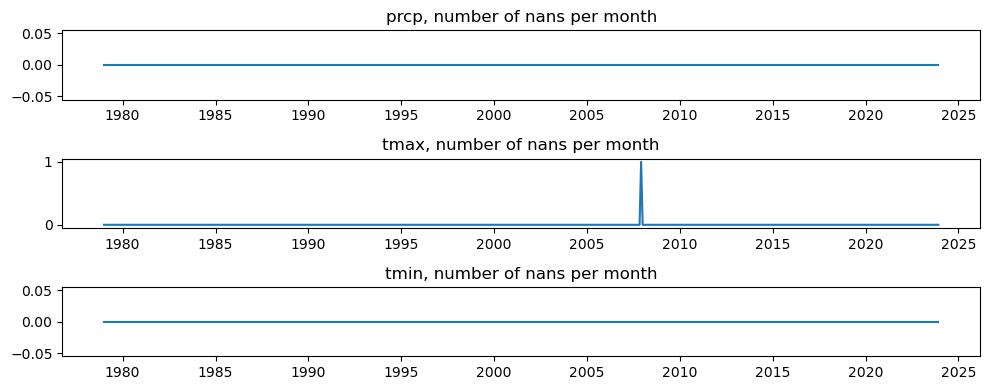

In [25]:
# create datetimes for the x axis
time_months=pd.date_range(tx.time.data[0],tx.time.data[-1],freq='MS')

# plot
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(311)
plt.plot(time_months,pr_nan_per_month)
plt.title('prcp, number of nans per month')

ax=fig.add_subplot(312)
plt.plot(time_months,tx_nan_per_month)
plt.title('tmax, number of nans per month')

ax=fig.add_subplot(313)
plt.plot(time_months,tn_nan_per_month)
plt.title('tmin, number of nans per month')

plt.tight_layout()
plt.show()

# Calculate climate change indicators

### Monthly Maximum Value of Daily Minimum Temperature (TNx)

- max(each month of daily minimum temperature values)

Here we are inputting daily data and pulling out 1 value per month.

In [26]:
# this is similar to how we found nans per month

# create an index for every month in the timeseries
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# replace the time coordinate with the new month_groups index
# now each day of data in any particular month has the same label
tn.coords['month_groups']=('time',month_groups)    
tn

<xarray.DataArray 'tmin' (time: 16425)>
array([ -1.097348,  -8.009786, -10.346189, ...,   1.085255,  -1.805873,
         1.301268], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

In [27]:
# groupby month and find the maximum value of each month
TNx=tn.groupby('month_groups').max()
TNx

<xarray.DataArray 'tmin' (month_groups: 540)>
array([ 7.149189 , 15.696419 , 17.327755 , 18.195263 , 20.149757 ,
       23.05989  , 24.1054   , 23.452171 , 22.083511 , 18.259205 ,
       12.190084 , 14.446995 , 12.164164 , 13.572573 , 13.161282 ,
       14.604254 , 20.232704 , 24.352516 , 27.293758 , 25.34618  ,
       24.90033  , 20.199871 , 13.954485 , 10.982136 ,  8.104834 ,
       12.684324 , 14.711395 , 18.267845 , 20.7304   , 24.096756 ,
       26.13247  , 25.27533  , 22.65897  , 19.714272 , 15.136509 ,
       13.360014 , 15.022455 , 12.502872 , 19.646877 , 18.115772 ,
       23.262081 , 22.84388  , 24.01381  , 24.364616 , 23.324291 ,
       21.404362 , 16.458515 , 18.92971  , 10.398035 , 10.710823 ,
       13.835245 , 16.767845 , 19.612312 , 22.363464 , 25.72118  ,
       25.648602 , 22.881897 , 18.874413 , 14.643999 , 14.766695 ,
        3.592741 , 13.413586 , 15.257477 , 20.307014 , 20.821991 ,
       23.184315 , 24.504593 , 22.289154 , 21.8554   , 20.291462 ,
       18.981556 , 16.201027 ,  6.5408955, 12.784554 , 19.069687 ,
       18.65667  , 22.883625 , 24.032818 , 24.11404  , 24.077747 ,
       23.70102  , 20.006325 , 19.002293 , 11.04262  ,  8.48329  ,
       13.990774 , 17.542038 , 16.93029  , 20.084087 , 23.542034 ,
       25.904362 , 26.374405 , 22.73328  , 23.60252  , 20.661278 ,
       12.101952 ,  7.9078293, 10.672804 , 12.827757 , 17.663006 ,
...
       14.917042 , 17.396877 , 18.872684 , 21.33524  , 24.978092 ,
       25.755741 , 25.109428 , 25.169914 , 21.808743 , 18.0069   ,
       16.702179 , 16.048954 , 14.887663 , 17.815079 , 21.732704 ,
       21.539154 , 23.07026  , 25.63823  , 23.979248 , 21.796642 ,
       23.177402 , 19.800678 , 13.287434 , 14.951603 , 18.114044 ,
       17.448723 , 16.672798 , 22.216576 , 24.762081 , 25.496525 ,
       24.831203 , 23.59042  , 22.77821  , 15.98674  , 13.7211895,
       10.061054 , 18.190079 , 16.328907 , 17.84446  , 22.985584 ,
       24.547794 , 24.699867 , 25.375557 , 24.473484 , 24.94526  ,
       12.9349   , 13.576029 , 16.121532 , 14.046074 , 18.98674  ,
       19.608856 , 20.872105 , 24.444107 , 24.552979 , 24.8433   ,
       25.149178 , 19.209663 , 17.224068 , 11.319117 , 14.811626 ,
       18.713696 , 17.652637 , 18.768997 , 20.38132  , 23.479824 ,
       25.031666 , 24.846756 , 22.474064 , 21.26957  , 12.525337 ,
       18.260933 , 19.175102 , 16.187202 , 16.902637 , 18.442383 ,
       22.665882 , 25.33754  , 26.583508 , 23.585236 , 22.46024  ,
       16.214851 , 17.953327 , 17.493652 , 16.857708 , 17.920494 ,
       18.378445 , 19.258053 , 20.068535 , 23.224064 , 25.114613 ,
       26.353668 , 23.52821  , 19.65379  , 15.79665  , 13.465429 ],
      dtype=float32)
Coordinates:
    lon           float64 -88.8
    lat           float64 33.5
  * month_groups  (month_groups) object MultiIndex
  * time_level_0  (month_groups) int64 1979 1979 1979 1979 ... 2023 2023 2023
  * time_level_1  (month_groups) int64 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Attributes:
    long_name:             Minimum air temperature at 2 meter (00-00LT)
    temporal_aggregation:  Min 00-00LT
    units:                 degrees_C
    standard_name:         2m_min_air_temperature

Text(0, 0.5, 'degrees C')

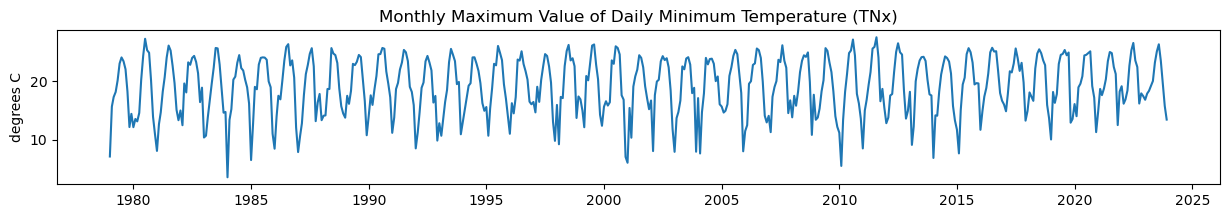

In [36]:
# using the monthly datetimes that we created earlier (time_months) for the x axis values, plot TNx

# plot
fig=plt.figure(figsize=(15,2))
plt.plot(time_months,TNx)
plt.title('Monthly Maximum Value of Daily Minimum Temperature (TNx)')
plt.ylabel('degrees C')

### Growing Season Length (GSL)

- annually, growing season starts on the first day of the first six consecutive day period where daily mean temperature is > 5C
- annually, growing season ends on the first day after 1 July of the first six consecutive day period where daily mean temperature is < 5C

Here we are inputting daily data, pulling out 2 dates per year, and calculating the number of days between the two dates.


In [40]:
t_mean=(tn+tx)/2

DataArrayGroupBy, grouped over 'year'
45 groups with labels 1979, 1980, 1981, ..., 2022, 2023.

In [44]:
# we'll want to group by years to find the start and end of the growing season for each year
# let's take a look at how to use groupby
t_mean.groupby(t_mean.time.dt.year)

DataArrayGroupBy, grouped over 'year'
45 groups with labels 1979, 1980, 1981, ..., 2022, 2023.

In [43]:
# how to access the group labels
t_mean.groupby(t_mean.time.dt.year).groups.keys()

dict_keys([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [42]:
# how to access the array indexes assigned to a group label
t_mean.groupby(t_mean.time.dt.year).groups[1979]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [125]:
# how to access the array data assigned to a group label
data_1979=t_mean[t_mean.groupby(t_mean.time.dt.year).groups[2023]]
data_1979

<xarray.DataArray (time: 365)>
array([16.6321   , 18.56292  , 18.886425 , 13.64891  ,  9.537909 ,
        7.5785046, 13.239888 , 10.779927 ,  8.292692 , 10.14902  ,
       17.363886 , 12.556319 ,  3.8676615,  2.8676877,  4.9700003,
       10.996569 , 17.248573 , 17.542751 , 12.7143135,  7.9599524,
        7.6051035,  8.202362 ,  5.6746774,  5.614275 ,  7.371925 ,
        3.9334326,  5.741733 ,  6.6377115, 11.545864 , 12.416033 ,
        5.788496 ,  3.0202904,  2.622002 ,  3.4944391,  3.9789505,
        9.911059 ,  9.605391 , 13.069159 , 18.19247  , 11.928401 ,
        9.691392 ,  6.1875634,  8.558801 , 10.569231 , 13.536568 ,
       18.58157  , 15.918249 ,  4.4780216,  4.3822756, 10.493031 ,
       16.697174 , 20.547544 , 21.801144 , 22.765163 , 15.09694  ,
       14.947492 , 16.48947  , 19.559818 , 17.532574 , 20.773077 ,
       19.074905 , 18.115757 , 14.027807 , 14.397227 , 17.568657 ,
       19.881298 , 15.710394 , 17.20378  , 11.594675 , 10.708207 ,
       12.814942 ,  8.272457 ,  5.4346123,  6.2210913, 12.3710375,
       10.044925 ,  7.342479 ,  1.3642588,  3.3361416,  8.483065 ,
       16.528969 , 20.779    , 22.07903  , 20.48735  , 19.20848  ,
       17.920422 , 14.099804 , 11.161424 , 13.273354 , 19.225056 ,
       17.825827 , 14.683201 , 18.716873 , 24.026457 , 23.501389 ,
       16.432613 , 10.980251 , 11.862213 , 14.389836 , 15.128897 ,
...
       24.630949 , 24.689667 , 25.251287 , 24.698765 , 24.829443 ,
       23.868404 , 23.444035 , 22.946522 , 22.471523 , 16.417496 ,
       14.810961 , 18.63528  , 22.487179 , 19.016014 , 18.371662 ,
       19.798485 , 19.572308 , 14.3825445, 13.978943 , 14.438044 ,
       15.958553 , 18.329136 , 21.287373 , 19.889322 , 21.33504  ,
       21.803028 , 21.230549 , 21.628887 , 22.135098 , 23.779995 ,
       23.752516 , 23.406176 , 13.612557 ,  9.142181 ,  6.5835185,
        7.391756 , 11.341109 , 14.940612 , 16.140938 , 18.42036  ,
       20.157309 , 21.87556  , 19.393415 , 13.83947  , 13.311129 ,
       15.016164 , 15.733801 , 15.686735 , 12.955706 , 18.114    ,
       18.473303 , 13.962924 , 12.030029 , 15.251793 , 14.320159 ,
        9.150887 ,  7.976795 ,  9.963117 ,  9.928767 , 10.482621 ,
        5.234084 ,  6.173981 ,  7.1929646,  8.429069 , 14.714284 ,
       15.866336 , 14.032075 , 10.112614 ,  9.01589  ,  6.6282363,
        7.537549 , 10.997584 , 17.508444 ,  8.227073 ,  5.3119206,
        6.7597256,  8.024466 , 10.286375 , 10.297197 , 10.689836 ,
        9.064892 ,  7.8591356,  3.5578036,  5.8729267,  6.511986 ,
       10.7352915, 13.760461 , 14.175232 , 14.54287  ,  7.878153 ,
        8.303731 ,  3.8486972,  4.7851276,  4.1380973,  8.600194 ],
      dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (2023, 1) (2023, 1) ... (2023, 12) (2023, 12)

In [126]:
data_1979_mask=xr.where(data_1979>5,1,0)
data_1979_mask

<xarray.DataArray (time: 365)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1])
Coordinates:
  * time          (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (2023, 1) (2023, 1) ... (2023, 12) (2023, 12)

In [127]:
windows=data_1979_mask.rolling(time=6,center=False).construct('window')
windows


<xarray.DataArray (time: 365, window: 6)>
array([[nan, nan, nan, nan, nan,  1.],
       [nan, nan, nan, nan,  1.,  1.],
       [nan, nan, nan,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.,  0.,  1.]])
Coordinates:
  * time          (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (2023, 1) (2023, 1) ... (2023, 12) (2023, 12)
Dimensions without coordinates: window

In [128]:
windows.sum('window')

<xarray.DataArray (time: 365)>
array([1., 2., 3., 4., 5., 6., 6., 6., 6., 6., 6., 6., 5., 4., 3., 3., 3.,
       3., 4., 5., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 4., 3.,
       2., 2., 2., 3., 4., 5., 6., 6., 6., 6., 6., 6., 6., 5., 4., 4., 4.,
       4., 4., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 4., 4., 4., 4., 4., 5., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5.,
       5., 6., 6., 6., 5., 4., 3., 3.])
Coordinates:
  * time          (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (2023, 1) (2023, 1) ... (2023, 12) (2023, 12)

In [129]:
np.where(windows.sum('window')==6)[0]

array([  5,   6,   7,   8,   9,  10,  11,  20,  21,  22,  23,  24,  40,
        41,  42,  43,  44,  45,  46,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [130]:
# put it all together
gs_start_ind=np.where(windows.sum('window')==6)[0][0]-5
gs_start_ind

0

In [76]:
t_mean

<xarray.DataArray (time: 16425)>
array([ 8.1353035, -4.288802 , -4.4386454, ...,  4.7851276,  4.1380973,
        8.600194 ], dtype=float32)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (2023, 12) (2023, 12)

In [102]:
# now let's search for the end of the growing season
# we know to only look after July 1, what index is that?
minval=t_mean.indexes['time'].get_loc('1979-07-01')
minval

181

In [108]:
# 0/1 mask for where t_mean is lt 5C
data_1979_mask=xr.where(data_1979<5,1,0)
data_1979_mask

<xarray.DataArray (time: 365)>
array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)

In [109]:
# # 0/1 mask for where t_mean is lt 5C
# data_1979_mask=xr.where(data_1979<5,1,0)

# divide up into 6-day windows
windows=data_1979_mask.rolling(time=6,center=False).construct('window')
windows


<xarray.DataArray (time: 365, window: 6)>
array([[nan, nan, nan, nan, nan,  0.],
       [nan, nan, nan, nan,  0.,  1.],
       [nan, nan, nan,  0.,  1.,  1.],
       ...,
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 1979-12-31
    lon           float64 -88.8
    lat           float64 33.5
    month_groups  (time) object (1979, 1) (1979, 1) ... (1979, 12) (1979, 12)
Dimensions without coordinates: window

In [110]:
np.where(windows.sum('window')==6)

(array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41, 337], dtype=int64),)

In [112]:
possible_inds=np.where(windows.sum('window')==6)[0]
possible_inds

array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41, 337], dtype=int64)

In [118]:
gs_end_ind=possible_inds[possible_inds>minval][0]
gs_end_ind

337

In [146]:
# functions to do what we did above for each year

def get_gs_start(data_1yr):
    mask=xr.where(data_1yr>5,1,0)
    windows=mask.rolling(time=6,center=False).construct('window')
    ind=np.where(windows.sum('window')==6)[0][0]-5
    return ind

def get_gs_end(data_1yr):
    mask=xr.where(data_1yr<5,1,0)
    windows=mask.rolling(time=6,center=False).construct('window')
    # sometimes it may be warm through the end of the year
    # in these cases we would end up with an error if no windows meet the <5C requirement
    # try/except works to pass in the last day of the year in these cases
    try:
        possible_inds=np.where(windows.sum('window')==6)[0]
        ind=possible_inds[possible_inds>minval][0]
    except:
        ind=364
    return ind

In [147]:
gs_start_list=[]
gs_end_list=[]
for label,group in t_mean.groupby(t_mean.time.dt.year):
    gs_start_list.append(get_gs_start(group))
    gs_end_list.append(get_gs_end(group))
gs_start_list

[50,
 12,
 22,
 0,
 5,
 39,
 47,
 13,
 12,
 27,
 0,
 2,
 4,
 0,
 0,
 22,
 8,
 12,
 0,
 1,
 15,
 6,
 26,
 8,
 41,
 11,
 0,
 7,
 2,
 4,
 1,
 14,
 26,
 4,
 7,
 46,
 16,
 28,
 9,
 43,
 0,
 0,
 0,
 49,
 0]

In [148]:
min(gs_end_list)
gs_end_list

[337,
 364,
 364,
 364,
 360,
 364,
 351,
 364,
 364,
 364,
 350,
 364,
 364,
 364,
 359,
 364,
 358,
 364,
 349,
 364,
 359,
 355,
 364,
 364,
 364,
 364,
 343,
 364,
 364,
 364,
 364,
 343,
 364,
 364,
 332,
 364,
 364,
 364,
 363,
 364,
 364,
 364,
 364,
 360,
 364]

In [149]:
len(gs_end_list),min(gs_end_list),max(gs_end_list)

(45, 332, 364)

In [152]:
assert all(gs_end_list)>181, f"error"


AssertionError: error

In [153]:
# double check our work
assert all(gs_start_list)>=0, "error: negative values in gs_start_list"
assert all(gs_start_list)<=364, "error: values>364 in gs_start_list"
assert all(gs_start_list)<=364, "error: values>364 in gs_end_list"
assert all(gs_end_list)>=minval, f"error: values<{minval} in gs_end_list" ????????????????


AssertionError: error: values<181 in gs_end_list

In [ ]:
# find the start and end of the growing season in 1979 first
# then we'll apply this to all of the years
N=6
xr.where(data_1979_mask.diff().eq(0).rolling(N-1).sum()==N-1)

### Warm Spell Duration Index (WSDI)

- 6 consecutive days of hot temperatures
- hot temperature threshold defined as > 90th percentile temperature for each calendar day using a centered 5-day window in the base period 1961-1990
- warm spells that contain dates for multiple years are assigned to the year when the spell ends

Here we first use daily data during the base period to determine the daily 90th percentile temperature threshold. Then using all years of daily data we decide whether each calendar day exceeds the hot threshold, then find occurrences where the threshold is exceeded for at least 6 consecutive days (this is a warm spell), then sum the number of days annually in the warm spells.

Notice that this is not the same as finding dangerous heat waves with respect to human health because it is based on a temperature threshold for each calendar day. This means that the WSDI will include winter warm spells where the temperature exceeds the 90th percentile of winter daily temperature, which would likely be a comfortable temperature.

### Monthly Maximum Consecutive 5-day Precipitation (Rx5day)

- max(5-day rolling mean precipitation within each month)

Here we are inputting daily data, for each month calculating the mean precipitation amount for each 5-day window of data values, then choosing the maximum of 5-day window value for each month.


### Maximum Length of Consecutive Dry Days (CDD)

- annually, during the growing season (using mean start and mean end)
- maximum length of consecutive days where precipitation is < 1mm

Here we are inputting daily data, subsetting to data during the growing season, determining whether each day falls under the precipitation threshold, and finding the longest period of consecutive days each year that meets the threshold requirement. 


### Annual Total Precip Amount Over 99th Percentile on Wet Days (R99pTOT)

- annually, the sum of precipitation when precipitation is > 99th percentile of wet day precipitation in the base period 1961-1990
- where a wet day is precipitation >= 1mm

Here we first use daily data during the base period to determine the 99th percentile of wet day precipitation. Then for each year of daily data we determine if each day exceeds the threshold and calculate an annual sum of precip on days that exceed the threshold. 

### Are the Changes In Value of These Indices Over Time Statistically Significant?

### Computing Climate Change Indices on Gridded Data

In [ ]:
# download/unzip data

In [ ]:
# repeat one of the above analysis

In [ ]:
# visualize

# Your Turn!

### Choose one of three coding mini-projects below to complete on your own and prepare to share your findings


**Option 1 (easiest):** Calculate the monthly mean daily temperature range (DTR) at the xx station a create a figure showing the DTR timeseries. 

&emsp;Hints:
- Use daily tmax and tmin data
- Calculate the daily temperature range as tmax-tmin
- For each month, find the mean of the range values you calculated in the previous step
- Plot your timeseries of monthly values. Include axis labels and a title. 

<br>
<br>

**Option 2 (moderate):** Calculate the cold spell duration index (CDSI) at the xx station and create a figure showing the CDSI timeseries. Extra: see if you can determine whether the change in the CDSI is statistically significant.

&emsp;Hints:
- Use daily tmin data
- Find the daily 10th percentile temperature using a centered 5-day window over the base period 1961-1990
- Using all data years, determine if each day exceeds the threshold (looking for days with tmin < threshold)
- Identify cold spells as periods of 6 consecutive days when the temperature exceeds the threshold
- Count how many total cold spell days there are annually (remember each cold spell is assigned to the year when the spell ends)
- Plot the timeseries of annual values. Include axis labels and a title.
- Extra Step: Determine statistical significance of the trend line (linear regression) or the difference in means between two 30-year periods (1941-1970) and (1991-2020).

<br>
<br>


**Option 3 (hardest):** Use a gridded dataset to compute the annual growing season length (GSL) at each grid cell. Then, calculate the trend in GSL at each grid cell and also determine whether each trend is statisically significant. Present your results in a figure that shows the GSL trend for each grid cell (on a map) and include an indication of whether each grid cell value is statistically significant.

&emsp;Hints:
- Use gridded daily tmax and tmin data
- Calculate daily mean temperature
- Use the same process we showed previously to determine the annual start/end of the growing season and find the annual GSL, except this time do the calculations at each grid cell.
- Calculate the trend (linear regression) in annual GSL at each grid cell.
- Determine if each trend is statistically significant.
- Plot the the map of trend values and indicate significance at each grid with hatching or some other visual indicator. Include a title and legend.



In [ ]:
# peek at the answer figure for option 1

In [ ]:
# peek at the answer figure for option 2

In [ ]:
# peek at the answer figure for option 3

Don't forget to create answer codes for these and put them in the repo. Direct learners to answers after the work-on-your-own session.